In [26]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy
import sys
import matplotlib.pyplot as plt

from tools.misc_tools import get_h5_data
from matplotlib.colors import Normalize, LightSource
from mpl_toolkits.mplot3d import Axes3D
from skimage.measure import marching_cubes
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **Windowing Technique:**

In [2]:

from tools.misc_tools import get_fpath_sim
from tools.plotter import plot_from_array
from tools.kolmogorov import TimeStepper3D
import copy 

material_params = {'W': 20, 'beta': 0.9, 'Re': 0.5, 'L':np.inf, 'eps': 1e-3}
system_params = {'Lx': 3*np.pi,  'Lz': np.pi, 'ndim': 3, 'n':1}
solver_params = {'Nx': 64, 'Ny': 64, 'Nz': 32}

system_params_temp = copy.deepcopy(system_params)
system_params_temp['ndim'] = 2
timestepper = TimeStepper3D(material_params=material_params, solver_params=solver_params, system_params=system_params_temp)
base_flow = timestepper.base_flow_full

data_fields, _ = get_h5_data(material_params, system_params, solver_params, suffix='recent-periodic', subdir='arrowhead_3D', s=-1)

x, y, z = data_fields['x'], data_fields['y'], data_fields['z']

fields = ['p', 'c11', 'c12', 'c22', 'u', 'v']

p = data_fields['p'][-1,:,:,:] - base_flow['p'][[0], None, :]
c11 = data_fields['c11'][-1,:,:,:] - base_flow['c11'][[0], None, :]
c12 = data_fields['c12'][-1,:,:,:] - base_flow['c12'][[0], None, :]
c22 = data_fields['c22'][-1,:,:,:] - base_flow['c22'][[0], None, :]
c33 = data_fields['c33'][-1,:,:,:] - base_flow['c33'][[0], None, :]

trace = c11 + c22 + c33


2025-02-27 15:58:13,597 cfd_tools.cartesian_systems.cartesian_system_base 0/1 INFO :: Baseflow converged!...


In [3]:
Lx = system_params['Lx']
Nx = solver_params['Nx']
Ny = solver_params['Ny']
Nz = solver_params['Nz']

In [4]:
from cfd_tools.cartesian_systems.misc_tools import shift_reflect

mean_c22_y = np.mean(c22, axis=(0,1))

Ny = mean_c22_y.shape[0]
if mean_c22_y[0] > mean_c22_y[Ny//2]:
    # u = shift_reflect(u, parity='odd')
    # v = shift_reflect(v, parity='even')
    p = shift_reflect(p, parity='even')
    trace = shift_reflect(trace, parity='even')
    c22 = shift_reflect(c22, parity='even')

In [5]:
def draw_surface(array1, x, y, z, ax=None, level_mult=0.7, color='tab:blue', zorder=1, level_val=None):

    if level_val is None:
        level_val = (np.max(array1) - np.min(array1)) * level_mult + np.min(array1)

    try:
        verts, faces, _, _ = marching_cubes(array1, level=level_val, step_size=1, spacing=(x[1]-x[0], y[1]-y[0], z[1]-z[0]))
        
        verts[:, 0] += x[0]
        verts[:, 1] += y[0]
        verts[:, 2] += z[0]

        # Fancy indexing: `verts[faces]` to generate a collection of triangles
        ls = LightSource(azdeg=45.0, altdeg=245.0)
        mesh = Poly3DCollection(verts[faces], shade=True, lightsource=ls, facecolors=color, zorder=zorder)

        ax.add_collection3d(mesh)
    except:
        pass

    return verts, level_val

In [6]:

def plot_3D_surface(array1, x, y, z, ax=None, level_mult=0.7, level_val=None, zorder=1):
    if not np.all(np.isclose(np.diff(x, n=2), 0)) or not np.all(np.isclose(np.diff(y, n=2), 0)) or not np.all(np.isclose(np.diff(z, n=2), 0)):
        raise Exception("Grids not equally spaced. Marching Cube Algorithm will be weird...")
    x, y, z = x, z, y

    if ax is None:
        fig = plt.figure(figsize=(20, 20))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel("x", labelpad=20, fontsize=32)
        ax.set_ylabel("z", labelpad=40, fontsize=32)
        ax.set_zlabel("y",labelpad=10, fontsize=32)

        ax.view_init(elev=30, azim=25, roll=0)

    if isinstance(level_mult, float) or level_mult is None: 
        verts, level_val = draw_surface(array1, x, y, z, ax, level_mult, 'tab:blue', zorder, level_val)
    elif isinstance(level_mult, list):
        verts, level_val = draw_surface(array1, x, y, z, ax, level_mult[0], 'tab:red', zorder)
        verts, level_val = draw_surface(array1, x, y, z, ax, level_mult[1], 'tab:red', zorder)

    plt.tight_layout()

    return ax, verts, level_val

In [7]:
# Tile the periodic solution...
roll_x = -3

trace_trans = np.roll(trace, shift=roll_x, axis=0)
trace_trans = np.roll(trace_trans, shift=-7, axis=1)
trace_tiled = np.tile(trace_trans, (1, 5, 1))

trace_tiled = trace_tiled[:, Nz//2:-Nz//2, :]

# Tile the periodic solution...
p_trans = np.roll(p, shift=roll_x, axis=0)
p_trans = np.roll(p_trans, shift=-7, axis=1)
p_tiled = np.tile(p_trans, (1, 5, 1))

x_tiled = x
y_tiled = y
z_tiled = np.concatenate([z-2*np.pi, z-1*np.pi, z , z+1*np.pi, z+2*np.pi])[Nz//2:-Nz//2]
p_tiled = p_tiled[:, Nz//2:-Nz//2, :]

Nz_tiled = Nz * 4




/tmp/ipykernel_31650/2384989075.py:126: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


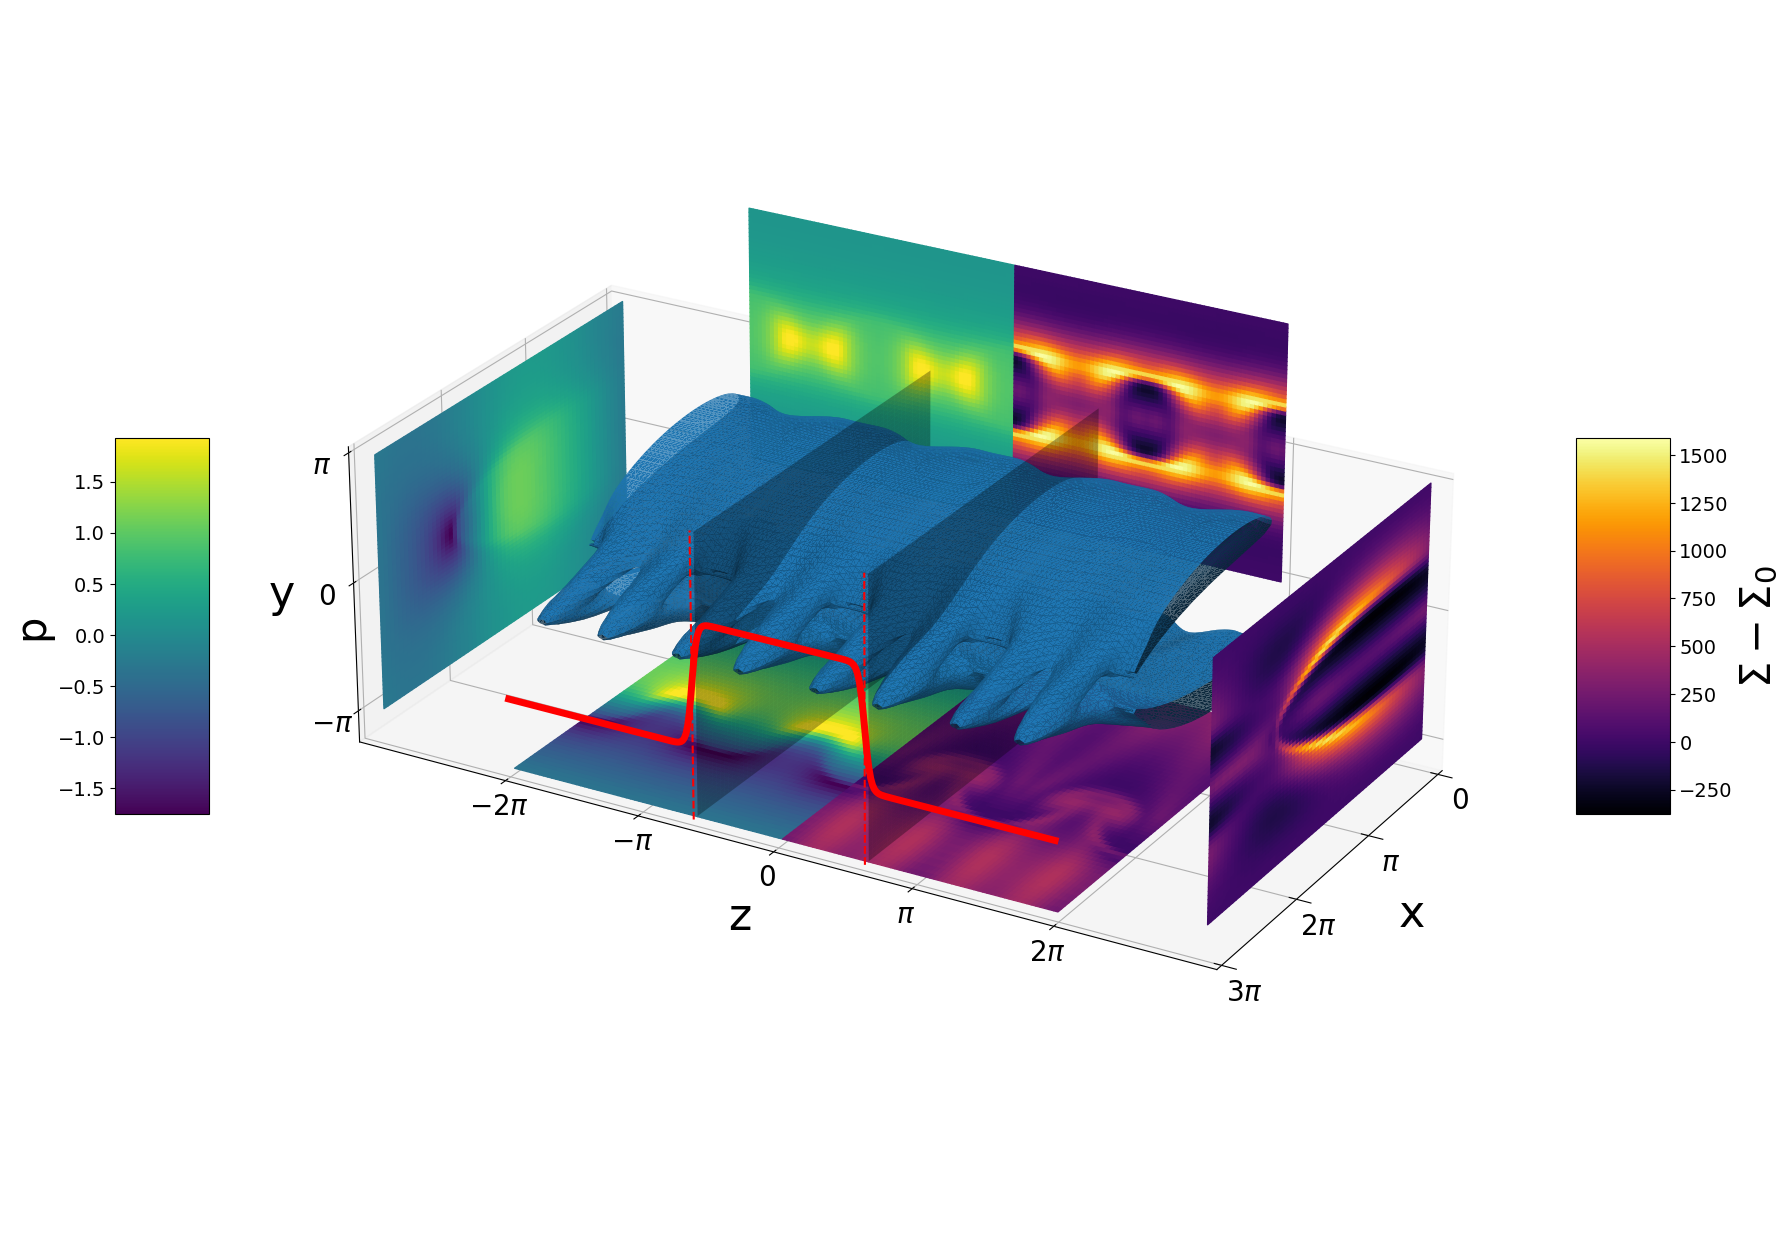

In [8]:
a, b = np.pi/2, np.pi/4
plt.rcParams['font.size'] = 40

z_idx_ab = np.argmin(np.abs(z_tiled-a-0.5*b))
z_idx__ab = np.argmin(np.abs(z_tiled+a+0.5*b))

ax, verts, level_val = plot_3D_surface(trace_tiled[:,:z_idx__ab+1,:], x_tiled, y_tiled, z_tiled[:z_idx__ab+1], ax=None, zorder=0.2, level_val=450)
ax, verts, level_val = plot_3D_surface(trace_tiled[:,z_idx__ab:z_idx_ab+1,:], x_tiled, y_tiled, z_tiled[z_idx__ab:z_idx_ab+1], ax=ax, zorder=0.5, level_val=450)
ax, verts, level_val = plot_3D_surface(trace_tiled[:,z_idx_ab:,:], x_tiled, y_tiled, z_tiled[z_idx_ab:], ax=ax, zorder=0.6, level_val=450)
ax.computed_zorder = False

ax.view_init(elev=25, azim=30, roll=0)

ax.set_xticks([0, np.pi, 2*np.pi, 3*np.pi], ['0', r'$\pi$', r'$2\pi$', r'$3\pi$'], fontsize=20)
ax.set_zticks([-np.pi, 0, np.pi, ], [r'$-\pi$', '0', r'$\pi$'], fontsize=20)
ax.set_yticks([0, 1*np.pi, 2*np.pi, -1*np.pi, -2*np.pi], ['0', r'$\pi$', r'$2\pi$', r'$-\pi$', r'$-2\pi$'], fontsize=20)

ax.computed_zorder = False

ax.set_xlim(0, 3*np.pi)  
ax.set_ylim(-3*np.pi, 3*np.pi)  

ax.set_zlim((-1.2*np.pi, np.pi))

ax.set_box_aspect((3*np.pi, 6*np.pi, 2*np.pi), zoom=0.9)

#### Plot windowing function

z_plot = np.linspace(np.min(z_tiled), np.max(z_tiled), 300)
window = 1/4 * (1 + np.tanh(6 * (a - z_plot) / b + 3)) * (1 + np.tanh(6 * (a + z_plot) / b + 3))

color = 'red'
ax.plot(z_plot, (window*3-2), zs=Lx, zdir='x', color=color, zorder=10, linewidth=5)

ax.plot([-a-0.5*b, -a-0.5*b], [-1.2*np.pi, np.pi], zs=Lx, zdir='x', color=color, linestyle='--', zorder=10)
ax.plot([a+0.5*b, a+0.5*b], [-1.2*np.pi, np.pi], zs=Lx, zdir='x', color=color, linestyle='--', zorder=10)

#### Plot windowing planes
xgrid, ygrid = np.meshgrid(x_tiled, y_tiled, sparse=False, indexing='ij')
ygrid = 1.1*ygrid - 0.3

ax.plot_surface(xgrid, (a+0.5*b) * np.ones_like(xgrid), ygrid, rstride=1, cstride=1,
                            color='k', shade=False, zorder=0.55, alpha=0.3)

ax.plot_surface(xgrid, -(a+0.5*b) * np.ones_like(xgrid), ygrid, rstride=1, cstride=1,
                            color='k', shade=False, zorder=0.25, alpha=0.3)


### Get key p, trace terms
min_p, max_p = np.min(p), np.max(p) * 0.9
min_tr, max_tr = np.min(trace), np.max(trace)

cmap_kind_p = 'viridis'
cmap_p = plt.get_cmap(cmap_kind_p)
cmap_kind_tr = 'inferno'
cmap_tr = plt.get_cmap(cmap_kind_tr)

norm_p = Normalize(vmin=min_p, vmax=max_p)
sm_p = plt.cm.ScalarMappable(cmap=cmap_kind_p, norm=norm_p)
norm_tr = Normalize(vmin=min_tr, vmax=max_tr)
sm_tr = plt.cm.ScalarMappable(cmap=cmap_kind_tr, norm=norm_tr)

### Get x-z plane

xgrid, zgrid = np.meshgrid(x_tiled, z_tiled, sparse=False, indexing='ij')

p_plane = p_tiled[:,:,Ny//2]
tr_plane = trace_tiled[:,:,Ny//2]

p_plane, xgrid_p, zgrid_p = p_plane[:,:Nz_tiled//2+1], xgrid[:, :Nz_tiled//2+1], zgrid[:,:Nz_tiled//2+1]
facecolors_p = cmap_p((p_plane - min_p) / (max_p - min_p))
tr_plane, xgrid_tr, zgrid_tr = tr_plane[:,Nz_tiled//2:], xgrid[:, Nz_tiled//2:], zgrid[:, Nz_tiled//2:]
facecolors_tr = cmap_tr((tr_plane - min_tr) / (max_tr - min_tr))

ax.plot_surface(xgrid_p, zgrid_p, -1.2*np.pi * np.ones_like(xgrid_p), rstride=1, cstride=1,
                            facecolors=facecolors_p, shade=False, zorder=0.1)
ax.plot_surface(xgrid_tr, zgrid_tr, -1.2*np.pi * np.ones_like(xgrid_tr), rstride=1, cstride=1,
                            facecolors=facecolors_tr, shade=False, zorder=0.1)

### Get x-y plane

xgrid, ygrid = np.meshgrid(x_tiled, y_tiled, sparse=False, indexing='ij')

p_plane = p_tiled[:,Nz_tiled//2,:]
tr_plane = trace_tiled[:,Nz_tiled//2,:]

p_plane, xgrid_p, ygrid_p = p_plane, xgrid, ygrid
facecolors_p = cmap_p((p_plane - min_p) / (max_p - min_p))
tr_plane, xgrid_tr, ygrid_tr = tr_plane, xgrid, ygrid
facecolors_tr = cmap_tr((tr_plane - min_tr) / (max_tr - min_tr))

ax.plot_surface(xgrid_p, -3*np.pi * np.ones_like(xgrid_p), ygrid_p, rstride=1, cstride=1,
                            facecolors=facecolors_p, shade=False, zorder=0.1)
ax.plot_surface(xgrid_tr, 3*np.pi * np.ones_like(xgrid_tr), ygrid_tr, rstride=1, cstride=1,
                            facecolors=facecolors_tr, shade=False, zorder=5)


## Get y-z plane

zgrid, ygrid = np.meshgrid(z_tiled, y_tiled, sparse=False, indexing='ij')

p_plane = p_tiled[Nx//2,:,:]
tr_plane = trace_tiled[Nx//2,:,:]

p_plane, zgrid_p, ygrid_p = p_plane[:Nz_tiled//2+1,:], zgrid[:Nz_tiled//2+1,:], ygrid[:Nz_tiled//2+1,:]
facecolors_p = cmap_p((p_plane - min_p) / (max_p - min_p))

tr_plane, zgrid_tr, ygrid_tr = tr_plane[Nz_tiled//2:,:], zgrid[Nz_tiled//2:,:], ygrid[Nz_tiled//2:,:]
facecolors_tr = cmap_tr((tr_plane - min_tr) / (max_tr - min_tr))

ax.plot_surface(np.zeros_like(zgrid_p), zgrid_p, ygrid_p+3, rstride=1, cstride=1,
                            facecolors=facecolors_p, shade=False, zorder=0.01)
ax.plot_surface(np.zeros_like(zgrid_tr), zgrid_tr, ygrid_tr + 3, rstride=1, cstride=1,
                            facecolors=facecolors_tr, shade=False, zorder=0.01)


sm_p.set_array([])  # Necessary for ScalarMappable to work with colorbar
cbar = plt.colorbar(sm_p, ax=ax, shrink=0.2, aspect=4, location='left', pad=0.03)
cbar.set_label(label='p', size=30)

sm_tr.set_array([])  # Necessary for ScalarMappable to work with colorbar
cbar = plt.colorbar(sm_tr, ax=ax, shrink=0.2, aspect=4, location='right')
cbar.set_label(label=r'$\Sigma - \Sigma_0$', size=30)


plt.tight_layout()

# Structure of Arrowhead

# Localisation

In [9]:
material_params = {'W': 20, 'beta': 0.9, 'Re': 0.5, 'L':np.infty, 'eps': 1e-3}
system_params = {'Lx': 3*np.pi,  'Lz': 8*np.pi, 'ndim': 3, 'n':1}
solver_params = {'Nx': 64, 'Ny': 64, 'Nz': 128}

Nz, Nx = solver_params['Nz'], solver_params['Nx']
system_params_temp = copy.deepcopy(system_params)
system_params_temp['ndim'] = 2
timestepper = TimeStepper3D(material_params=material_params, solver_params=solver_params, system_params=system_params_temp)
base_flow = timestepper.base_flow_full

suffix_end = f'recent-a-{np.pi/2:.4g}-b-{np.pi/4:.4g}-Lz-orig-3,14'

data_fields, _ = get_h5_data(material_params, system_params, solver_params, suffix=suffix_end, subdir='windows', s=-1)

x, y, z = data_fields['x'], data_fields['y'], data_fields['z']


2025-02-27 15:58:30,926 cfd_tools.cartesian_systems.cartesian_system_base 0/1 INFO :: Baseflow converged!...


In [10]:

# fields = ['p', 'c11', 'c12', 'c22', 'u', 'v']

# plt.figure(figsize=(10, 5))
# for field_name in fields:
#     base_field = base_flow[field_name]
#     field_array = data_fields[field_name][-1,:,:,:] - base_field[:, None, :]
#     field_int = np.linalg.norm(field_array, axis=(0,2))
#     field_int /= np.max(field_int)

#     plt.plot(z, field_int, linewidth=2)

# plt.legend(fields, fontsize=14)

# plt.xlabel('z', fontsize=14)
# plt.ylabel(r'$|f|_{\infty, x, y}/|f|_{\infty, x, y, z}$', fontsize=14)
# plt.xticks([-4*np.pi, -2*np.pi, 0, 2*np.pi, 4*np.pi], ['-4$\pi$', '-2$\pi$', '0', '2$\pi$', '4$\pi$'], fontsize=14)


In [11]:
p = data_fields['p'][-1,:,:,:]
c22 = data_fields['c22'][-1,:,:,:]
c11 = data_fields['c11'][-1,:,:,:]
u = data_fields['u'][-1,:,:,:]
c33 = data_fields['c33'][-1,:,:,:]
tr = c11 + c22 + c33

Tr = base_flow['c11'] + base_flow['c22'] + base_flow['c33']
U = base_flow['u']

mean_c22_y = np.mean(c22, axis=(0,1))

Ny = mean_c22_y.shape[0]
if mean_c22_y[0] > mean_c22_y[Ny//2]:
    u = shift_reflect(u, parity='odd')
    # v = shift_reflect(v, parity='even')
    p = shift_reflect(p, parity='even')
    c22 = shift_reflect(c22, parity='even')
    c33 = shift_reflect(c33, parity='even')
    c11 = shift_reflect(c11, parity='even')

roll_x = 9
u = np.roll(u, axis=0, shift=roll_x)
p = np.roll(p, axis=0, shift=roll_x)
c22 = np.roll(c22, axis=0, shift=roll_x)
c33 = np.roll(c33, axis=0, shift=roll_x)
c11 = np.roll(c11, axis=0, shift=roll_x)

u_full = data_fields['u'][-1,:,:,:]

p = p - base_flow['p'][:, None, :]
u = u - base_flow['u'][:, None, :]
c22 = c22  - base_flow['c22'][:, None, :]
c11 = c11  - base_flow['c11'][:, None, :]
c33 = c33  - base_flow['c33'][:, None, :]
trace = c11 + c22 + c33



Text(0, 6.283185307179586, '$1$')

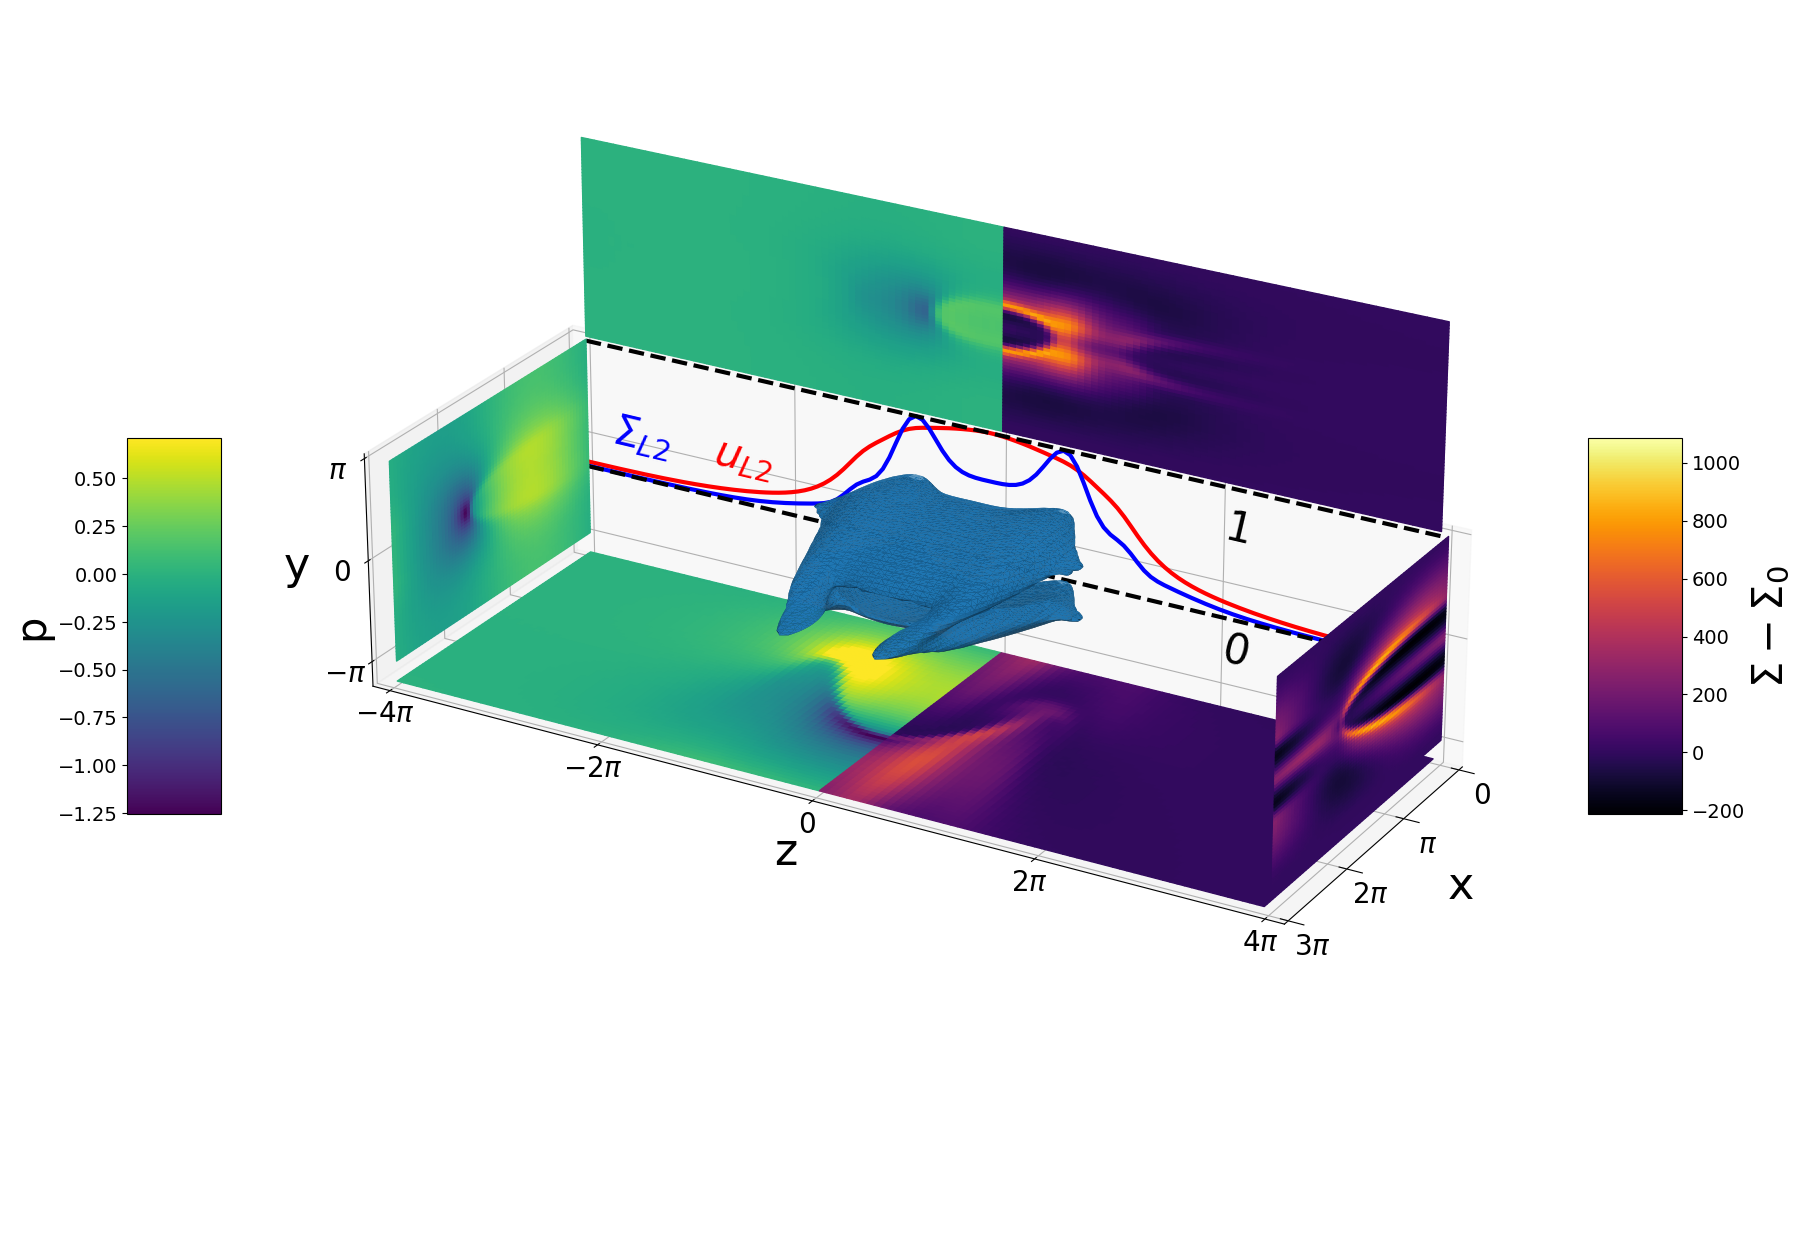

In [12]:
plt.rcParams['font.size'] = 40

ax, verts, level_val = plot_3D_surface(trace, x, y, z, ax=None, level_mult=0.41, zorder=0.2, level_val=450)
# ax, verts, level_val = plot_3D_surface(p, x, y, z, ax=ax, level_mult=[0.9,0.1], zorder=0.2)

ax.view_init(elev=25, azim=30, roll=0)

ax.computed_zorder = False

ax.set_box_aspect((np.max(x)-np.min(x), np.max(z)-np.min(z), np.max(y)-np.min(y)), zoom=0.9)
ax.set_xlim(0, 3*np.pi)  
ax.set_ylim(-4*np.pi, 4*np.pi)  

ax.set_zlim((-1.2*np.pi, np.pi))

ax.set_xticks([0, np.pi, 2*np.pi, 3*np.pi], ['0', r'$\pi$', r'$2\pi$', r'$3\pi$'], fontsize=20)
ax.set_zticks([-np.pi, 0, np.pi, ], [r'$-\pi$', '0', r'$\pi$'], fontsize=20)
ax.set_yticks([0, 2*np.pi, 4*np.pi, -2*np.pi, -4*np.pi], ['0', r'$2\pi$', r'$4\pi$', r'$-2\pi$', r'$-4\pi$'], fontsize=20)
    
### Get key p, trace terms
min_p, max_p = np.min(p), np.max(p) * 0.6
min_tr, max_tr = np.min(trace), np.max(trace)

cmap_kind_p = 'viridis'
cmap_p = plt.get_cmap(cmap_kind_p)
cmap_kind_tr = 'inferno'
cmap_tr = plt.get_cmap(cmap_kind_tr)

norm_p = Normalize(vmin=min_p, vmax=max_p)
sm_p = plt.cm.ScalarMappable(cmap=cmap_kind_p, norm=norm_p)
norm_tr = Normalize(vmin=min_tr, vmax=max_tr)
sm_tr = plt.cm.ScalarMappable(cmap=cmap_kind_tr, norm=norm_tr)

### Get x-z plane

xgrid, zgrid = np.meshgrid(x, z, sparse=False, indexing='ij')

p_plane = p[:,:,Ny//2]
tr_plane = trace[:,:,Ny//2]

p_plane, xgrid_p, zgrid_p = p_plane[:,:Nz//2+1], xgrid[:, :Nz//2+1], zgrid[:,:Nz//2+1]
facecolors_p = cmap_p((p_plane - min_p) / (max_p - min_p))
tr_plane, xgrid_tr, zgrid_tr = tr_plane[:,Nz//2:], xgrid[:, Nz//2:], zgrid[:,Nz//2:]
facecolors_tr = cmap_tr((tr_plane - min_tr) / (max_tr - min_tr))

ax.plot_surface(xgrid_p, zgrid_p, -1.2*np.pi * np.ones_like(xgrid_p), rstride=1, cstride=1,
                            facecolors=facecolors_p, shade=False, zorder=0.1)
ax.plot_surface(xgrid_tr, zgrid_tr, -1.2*np.pi * np.ones_like(xgrid_tr), rstride=1, cstride=1,
                            facecolors=facecolors_tr, shade=False, zorder=0.1)

### Get x-y plane

xgrid, ygrid = np.meshgrid(x, y, sparse=False, indexing='ij')

p_plane = p[:,Nz//2,:]
tr_plane = trace[:,Nz//2,:]

p_plane, xgrid_p, ygrid_p = p_plane, xgrid, ygrid
facecolors_p = cmap_p((p_plane - min_p) / (max_p - min_p))
tr_plane, xgrid_tr, ygrid_tr = tr_plane, xgrid, ygrid
facecolors_tr = cmap_tr((tr_plane - min_tr) / (max_tr - min_tr))

ax.plot_surface(xgrid_p, -4*np.pi * np.ones_like(xgrid_p), ygrid_p, rstride=1, cstride=1,
                            facecolors=facecolors_p, shade=False, zorder=0.1)
ax.plot_surface(xgrid_tr, 4*np.pi * np.ones_like(xgrid_tr), ygrid_tr, rstride=1, cstride=1,
                            facecolors=facecolors_tr, shade=False, zorder=0.1)


### Get y-z plane

zgrid, ygrid = np.meshgrid(z, y, sparse=False, indexing='ij')

p_plane = p[Nx//2,:,:]
tr_plane = trace[Nx//2,:,:]

p_plane, zgrid_p, ygrid_p = p_plane[:Nz//2+1,:], zgrid[:Nz//2+1,:], ygrid[:Nz//2+1,:]
facecolors_p = cmap_p((p_plane - min_p) / (max_p - min_p))

tr_plane, zgrid_tr, ygrid_tr = tr_plane[Nz//2:,:], zgrid[Nz//2:,:], ygrid[Nz//2:,:]
facecolors_tr = cmap_tr((tr_plane - min_tr) / (max_tr - min_tr))

ax.plot_surface(np.zeros_like(zgrid_p), zgrid_p, ygrid_p+2*np.pi, rstride=1, cstride=1,
                            facecolors=facecolors_p, shade=False, zorder=0.01)
ax.plot_surface(np.zeros_like(zgrid_tr), zgrid_tr, ygrid_tr +2*np.pi, rstride=1, cstride=1,
                            facecolors=facecolors_tr, shade=False, zorder=0.01)


sm_p.set_array([])  # Necessary for ScalarMappable to work with colorbar
cbar = plt.colorbar(sm_p, ax=ax, shrink=0.2, aspect=4, location='left', pad=0.03)
cbar.set_label(label='p', size=30)

sm_tr.set_array([])  # Necessary for ScalarMappable to work with colorbar
cbar = plt.colorbar(sm_tr, ax=ax, shrink=0.2, aspect=4, location='right')
cbar.set_label(label=r'$\Sigma - \Sigma_0$', size=30)

### Showing max trace, u over z
color = 'red'
u_metric = np.linalg.norm(u, axis=(0,2))
u_metric /= np.max(u_metric)
ax.plot(z, u_metric*4-1, zs=0, zdir='x', color='red', zorder=0.01, linewidth=3)
trace_metric = np.linalg.norm(trace, axis=(0,2))
trace_metric /= np.max(trace_metric)
ax.plot(z, trace_metric*4-1, zs=0, zdir='x', color='blue', zorder=0.01, linewidth=3)
ax.plot(z, -1 * np.ones_like(z), zs=0, zdir='x', color='black', linestyle='--', zorder=0.01, linewidth=3)
ax.plot(z, 3 * np.ones_like(z), zs=0, zdir='x', color='black', linestyle='--', zorder=0.01, linewidth=3)

ax.text(0,-2.8*np.pi, -0.4, r'$u_{L2}$', 'y', color='red', fontsize=30)
ax.text(0,-3.8*np.pi, -0.5, r'$\Sigma_{L2}$', 'y', color='blue', fontsize=30)
ax.text(0,2*np.pi, -0.8 *np.pi, r'$0$','y',  color='black', fontsize=30)
ax.text(0,2*np.pi, 0.4*np.pi, r'$1$', 'y', color='black', fontsize=30)


In [13]:

# def set_ticks(x=True, z=True):
#     if x:
#         plt.xticks([0,  np.max(xx)], ['0', r'$3\pi$'], fontsize=20)
#         plt.xlabel('x', fontsize=22)
#     else:
#         plt.xticks([])
#     if z:
#         plt.yticks([0, 2*np.pi, np.max(zz), -2*np.pi, np.min(zz)], ['0', r'$2\pi$', r'$4\pi$', r'$-2\pi$', r'$-4\pi$'], fontsize=20)
#         plt.ylabel('z', fontsize=22)
#     else:
#         plt.yticks([])


# xx, zz = np.meshgrid(x, z, indexing='ij', sparse=False)

# cmap_kind = 'viridis'

# plt.subplots(2,2, figsize=(10,16))

# ax = plt.subplot(2,2,1)
# plt.pcolormesh(xx, zz, c11[:,:,Ny//2], cmap=cmap_kind, shading='gouraud',)
# set_ticks(x=False, z=True)
# ax.set_aspect(1)
# plt.colorbar(location='right', ticks=[0,250,500])
# ax = plt.subplot(2,2,2)
# plt.pcolormesh(xx, zz, u[:,:,Ny//2], cmap=cmap_kind, shading='gouraud',)
# set_ticks(x=False, z=False)
# ax.set_aspect(1)
# plt.colorbar(location='right', ticks=[-0.15, -0.1, -0.05, 0, 0.1])
# ax = plt.subplot(2,2,3)
# plt.pcolormesh(xx, zz, c22[:,:,Ny//2], cmap=cmap_kind, shading='gouraud',)
# set_ticks(x=True, z=True)
# ax.set_aspect(1)
# plt.colorbar(location='right')
# ax = plt.subplot(2,2,4)
# plt.pcolormesh(xx, zz, p[:,:,Ny//2], cmap=cmap_kind, shading='gouraud',)
# set_ticks(x=True, z=False)
# ax.set_aspect(1)
# plt.colorbar(location='right')
# plt.tight_layout()
# # min_val, max_val = np.min(field), np.max(field)


# How Subcritical is the AH

In [14]:
from tools.misc_tools import get_AH_W_list

W_list_2D = get_AH_W_list(eps=1e-3, beta=0.9, Re=0.5, L=np.infty, Lx=3*np.pi, Nx=128, Ny=256, ndim=2, Nz=None, Lz=None, subdir='arrowhead_2D', suffix='recent-')
# W_list_3D = get_AH_W_list(eps=1e-3, beta=0.9, Re=0.5, L=np.infty, Lx=3*np.pi, Nx=64, Ny=64, ndim=3, Nz=128, Lz=8*np.pi, subdir='arrowhead_3D', suffix='recent-localised')

W_list_3D = [17,18,19,20]

In [15]:
from tools.misc_tools import get_metric_from_params

material_params = {'beta': 0.9, 'Re': 0.5, 'L':np.inf, 'eps': 1e-3}
solver_params = {'Nx': 128, 'Ny': 256,}
system_params = {'Lx': 3*np.pi,  'ndim': 2, 'n': 1}

metric_list_2D = []
W_list_2D_plot = []
for W in reversed(W_list_2D):
    material_params['W'] = W
    t_all, metric_all = get_metric_from_params(material_params, system_params, solver_params, suffix='recent-', subdir='arrowhead_2D', metric='trace', deviation=True)
    metric_list_2D.append(metric_all[-1])
    W_list_2D_plot.append(W)


material_params = {'beta': 0.9, 'Re': 0.5, 'L':np.inf, 'eps': 1e-3}
solver_params = {'Nx': 64, 'Ny': 64, 'Nz': 128}
system_params = {'Lx': 3*np.pi,  'ndim': 3, 'n': 1, 'Lz': 8*np.pi}

metric_list_3D = []
W_list_3D_plot = []
for W in reversed(W_list_3D):
    material_params['W'] = W
    t_all, metric_all = get_metric_from_params(material_params, system_params, solver_params, suffix='recent-localised', subdir='arrowhead_3D', metric='trace', deviation=True)
    metric_list_3D.append(metric_all[-1])
    W_list_3D_plot.append(W)



In [16]:
material_params['W'] = 20
data_fields, data_metric = get_h5_data(material_params, system_params, solver_params, suffix='recent-localised', subdir='arrowhead_3D', s=-1)

[0.09459101838274936, 0.09024380908558545, 0.07779460043171338, 0.05485459070280099]
[20, 19, 18, 17]


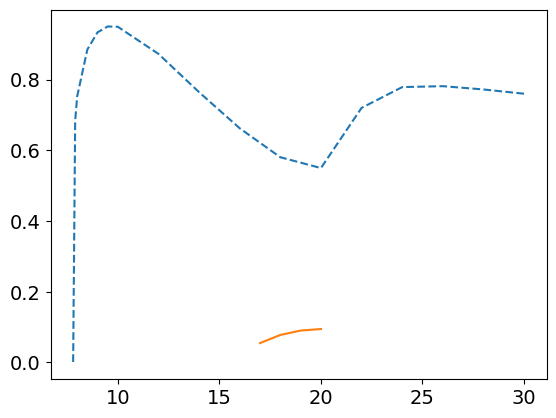

In [17]:
plt.plot(W_list_2D_plot, metric_list_2D, linestyle='--')
plt.plot(W_list_3D_plot, metric_list_3D, linestyle='-')
print(metric_list_3D)
print(W_list_3D_plot)

# Lz Bifurcation Plot

([<matplotlib.axis.XTick at 0x7fa7dffa3710>,
 [Text(0.0, 0, '0'),
  Text(3.141592653589793, 0, '$\\pi$'),
  Text(6.283185307179586, 0, '$2\\pi$'),
  Text(9.42477796076938, 0, '$3\\pi$'),
  Text(12.566370614359172, 0, '$4\\pi$'),
  Text(15.707963267948966, 0, '$5\\pi$'),
  Text(18.84955592153876, 0, '$6\\pi$'),
  Text(21.991148575128552, 0, '$7\\pi$'),
  Text(25.132741228718345, 0, '$8\\pi$')])

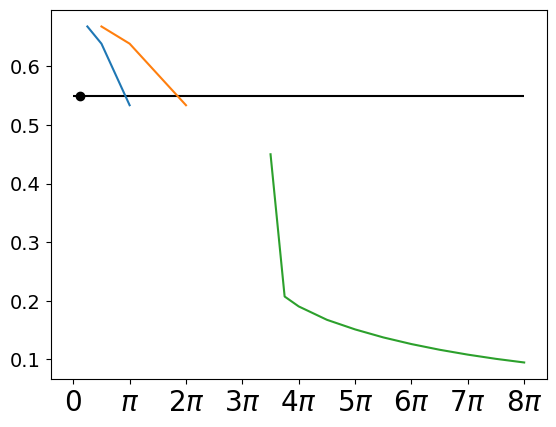

In [ ]:
from tools.misc_tools import get_metric_from_params

material_params = {'W':20, 'beta': 0.9, 'Re': 0.5, 'L':np.inf, 'eps': 1e-3}
solver_params = {'Nx': 64, 'Ny': 64, 'Nz': 128}
system_params = {'Lx': 3*np.pi,  'ndim': 3, 'n': 1, 'Lz': 8*np.pi}

# 2D AH
metric_list = []
Lz_list_plot = [np.pi/8]
Nz_list = [16]
for Lz, Nz in zip(Lz_list_plot, Nz_list):
    system_params['Lz'] = Lz
    solver_params['Nz'] = Nz
    t_all, metric_all = get_metric_from_params(material_params, system_params, solver_params, suffix='recent-periodic', subdir='arrowhead_3D', metric='trace', deviation=True)
    metric_list.append(metric_all[-1])
plt.hlines(metric_list[0], 0, 8*np.pi, color='k')
plt.scatter(x=[np.pi/8], y=[metric_list[0]], color='k')

# m=1 mode
metric_list = []
Lz_list_plot = np.array([np.pi/4, np.pi/2, np.pi])
Nz_list = [16,16,32]
for Lz, Nz in zip(Lz_list_plot, Nz_list):
    system_params['Lz'] = Lz
    solver_params['Nz'] = Nz
    t_all, metric_all = get_metric_from_params(material_params, system_params, solver_params, suffix='recent-periodic', subdir='arrowhead_3D', metric='trace', deviation=True)
    metric_list.append(metric_all[-1])
plt.plot(Lz_list_plot, metric_list)

# m=2 mode
plt.plot(Lz_list_plot*2, metric_list)


# localised mode
metric_list = []
Lz_list_plot = [3.75*np.pi, 3.5*np.pi, ]
Nz_list =      [         64, 56, ]

Lz_list_plot = [8*np.pi, 7.5*np.pi, 7*np.pi, 6.5*np.pi, 6*np.pi, 5.5*np.pi, 5*np.pi, 4.5*np.pi, 4*np.pi, 3.75*np.pi, 3.5*np.pi]
Nz_list =      [128,     120,       112,     104,       96,      88,        80,      72,        64,      64,         56]
for Lz, Nz in zip(Lz_list_plot, Nz_list):
    system_params['Lz'] = Lz
    solver_params['Nz'] = Nz
    t_all, metric_all = get_metric_from_params(material_params, system_params, solver_params, suffix='recent-localised', subdir='arrowhead_3D', metric='trace', deviation=True)
    if len(metric_all) == 0:
        t_all, metric_all = get_metric_from_params(material_params, system_params, solver_params, suffix='recent-localised-yz', subdir='arrowhead_3D', metric='trace', deviation=True)

    metric_list.append(metric_all[-1])
plt.plot(Lz_list_plot, metric_list)

plt.xticks([0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi, 5*np.pi, 6*np.pi, 7*np.pi, 8*np.pi], ['0', r'$\pi$', r'$2\pi$', r'$3\pi$', r'$4\pi$', r'$5\pi$', r'$6\pi$',  r'$7\pi$', r'$8\pi$'], fontsize=20)
